# Imports

In [2]:
# !pip install numpy pandas matplotlib scikit-learn seaborn tqdm xgboost lightgbm optuna

In [ ]:
import numpy as np
np.random.seed(420)
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

matplotlib.rcParams['figure.figsize'] = [20, 10]

DEV = False

c:\Users\Kanan\OneDrive\Masaüstü\Asan\Xidmətdən imtinanın proqnozlaşdırılması\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Processing

## Loading and Initial Cleaning

In [4]:
train_df = pd.read_csv('queue_dataset_train.csv')
test_df = pd.read_csv('queue_dataset_test.csv')

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}\n")

train_df.info()

Training data shape: (4510024, 13)
Test data shape: (364162, 12)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4510024 entries, 0 to 4510023
Data columns (total 13 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   id                         int64  
 1   date                       object 
 2   branch_name                object 
 3   customer_gender            object 
 4   customer_age_appl          object 
 5   customer_city              object 
 6   service_name_organization  object 
 7   service_name               object 
 8   service_name_2             object 
 9   time_start_process         object 
 10  operator_count             int64  
 11  previous_customer_count    float64
 12  service_canceled           int64  
dtypes: float64(1), int64(3), object(9)
memory usage: 447.3+ MB


In [5]:
missing_data = pd.DataFrame({
    'Missing Values': train_df.isnull().sum(),
    'Percentage Missing': (train_df.isnull().sum() / len(train_df)) * 100
}).sort_values(by='Percentage Missing', ascending=False)

# plt.figure(figsize=(12, 6))
# sns.heatmap(train_df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
# plt.title('Missing Values Heatmap', fontsize=14, pad=20)
# plt.xlabel('Features', fontsize=12)
# plt.ylabel('Observations', fontsize=12)
# plt.show()

missing_data[missing_data['Percentage Missing'] > 0]

,Missing Values,Percentage Missing
customer_age_appl,32616,0.723189
time_start_process,29213,0.647735


C:\Users\Kanan\AppData\Local\Temp\ipykernel_1300\3991734553.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=target_dist.index, y=target_dist.values, palette='Set2')


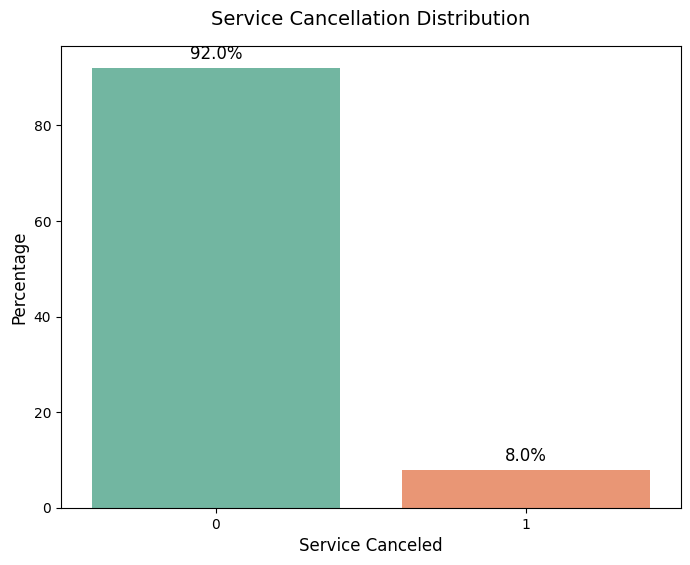

In [6]:
target_dist = train_df['service_canceled'].value_counts(normalize=True) * 100

plt.figure(figsize=(8, 6))
ax = sns.barplot(x=target_dist.index, y=target_dist.values, palette='Set2')
plt.title('Service Cancellation Distribution', fontsize=14, pad=15)
plt.xlabel('Service Canceled', fontsize=12)
plt.ylabel('Percentage', fontsize=12)


for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10),
                textcoords='offset points',
                fontsize=12)

plt.show()

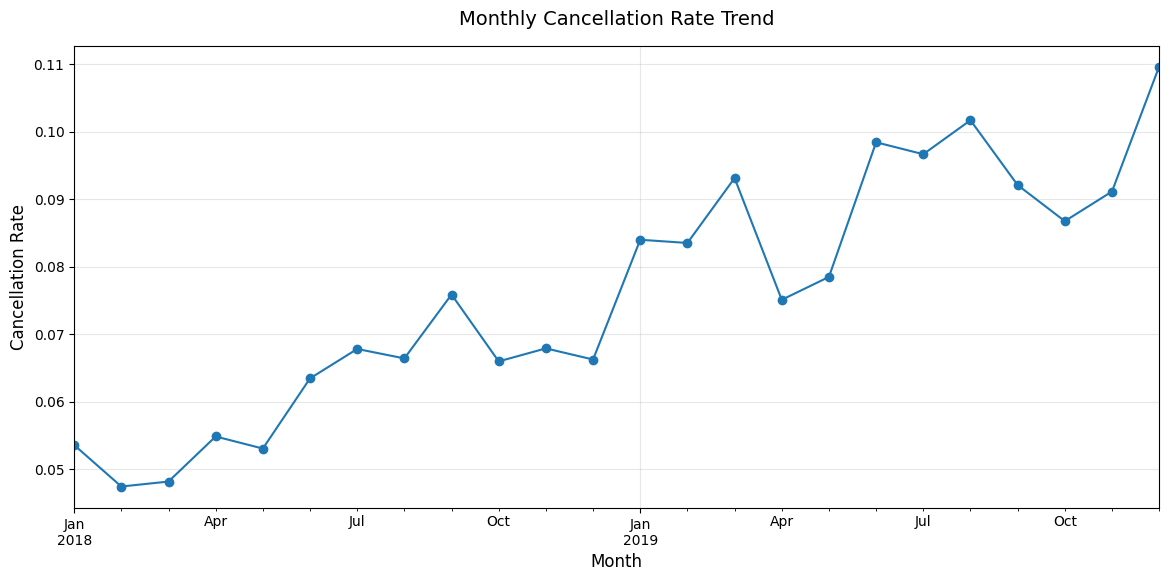

In [7]:

train_df['date'] = pd.to_datetime(train_df['date'])
train_df['year_month'] = train_df['date'].dt.to_period('M')

monthly_rates = train_df.groupby('year_month')['service_canceled'].mean()

plt.figure(figsize=(14, 6))
monthly_rates.plot(marker='o', linestyle='-')
plt.title('Monthly Cancellation Rate Trend', fontsize=14, pad=15)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Cancellation Rate', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

C:\Users\Kanan\AppData\Local\Temp\ipykernel_1300\1757369312.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train_df['hour'] = pd.to_datetime(train_df['time_start_process']).dt.hour


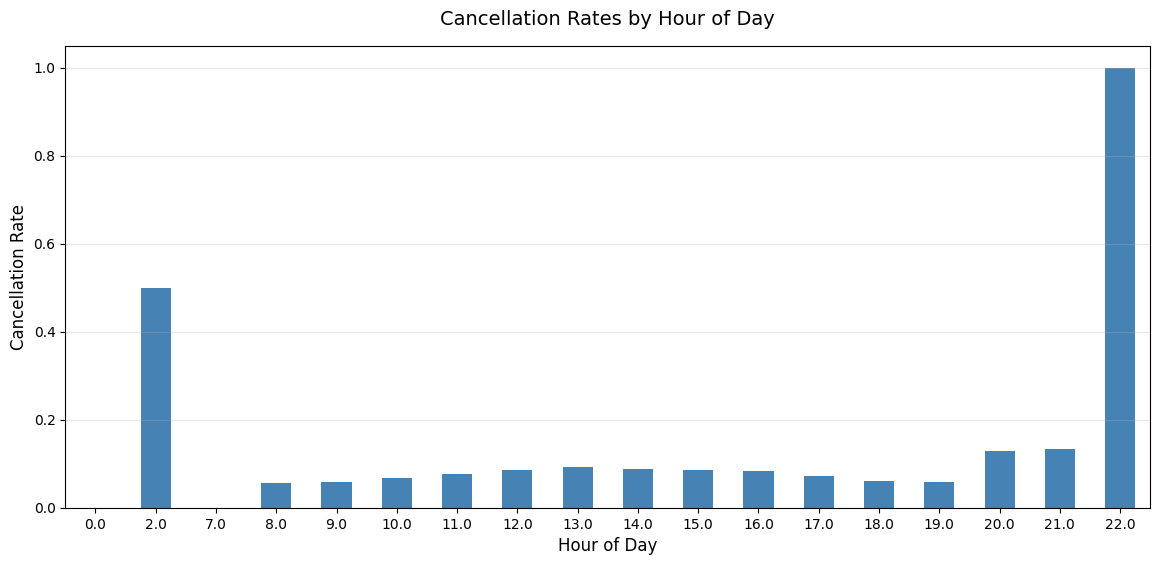

In [8]:
# Extract hour from timestamp
train_df['hour'] = pd.to_datetime(train_df['time_start_process']).dt.hour

# Calculate hourly cancellation rates
hourly_rates = train_df.groupby('hour')['service_canceled'].mean()

plt.figure(figsize=(14, 6))
hourly_rates.plot(kind='bar', color='steelblue')
plt.title('Cancellation Rates by Hour of Day', fontsize=14, pad=15)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Cancellation Rate', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.show()

C:\Users\Kanan\AppData\Local\Temp\ipykernel_1300\2580314313.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='mean', y=service_cancel.index, data=service_cancel, palette='RdBu_r')


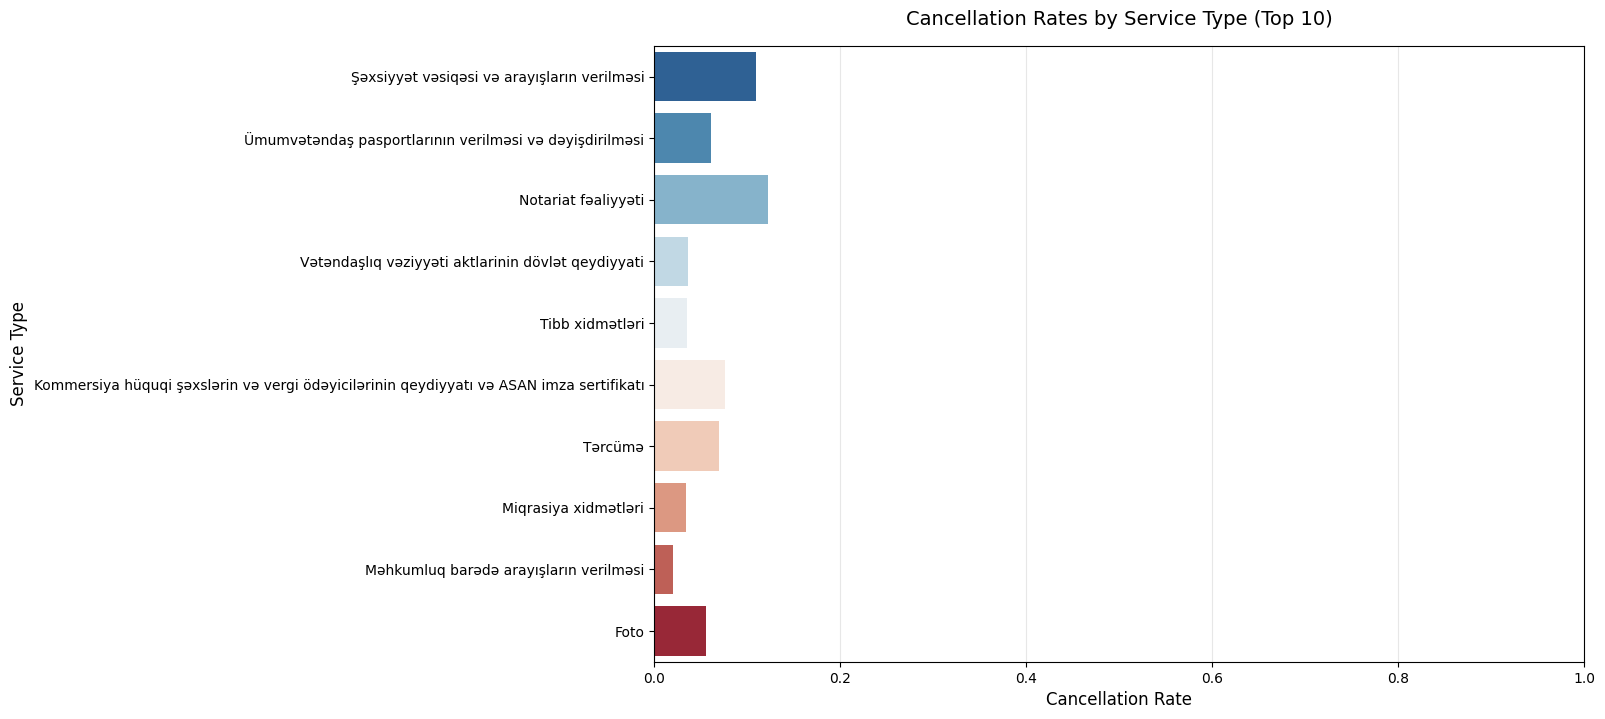

In [9]:

service_cancel = train_df.groupby('service_name_2')['service_canceled']\
                        .agg(['mean', 'count'])\
                        .sort_values('count', ascending=False)\
                        .head(10)

plt.figure(figsize=(12, 8))
sns.barplot(x='mean', y=service_cancel.index, data=service_cancel, palette='RdBu_r')
plt.title('Cancellation Rates by Service Type (Top 10)', fontsize=14, pad=15)
plt.xlabel('Cancellation Rate', fontsize=12)
plt.ylabel('Service Type', fontsize=12)
plt.xlim(0, 1)
plt.grid(axis='x', alpha=0.3)
plt.show()

C:\Users\Kanan\AppData\Local\Temp\ipykernel_1300\2784820132.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x='service_canceled', y='branch_name',
C:\Users\Kanan\AppData\Local\Temp\ipykernel_1300\2784820132.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='service_canceled', y='branch_name',


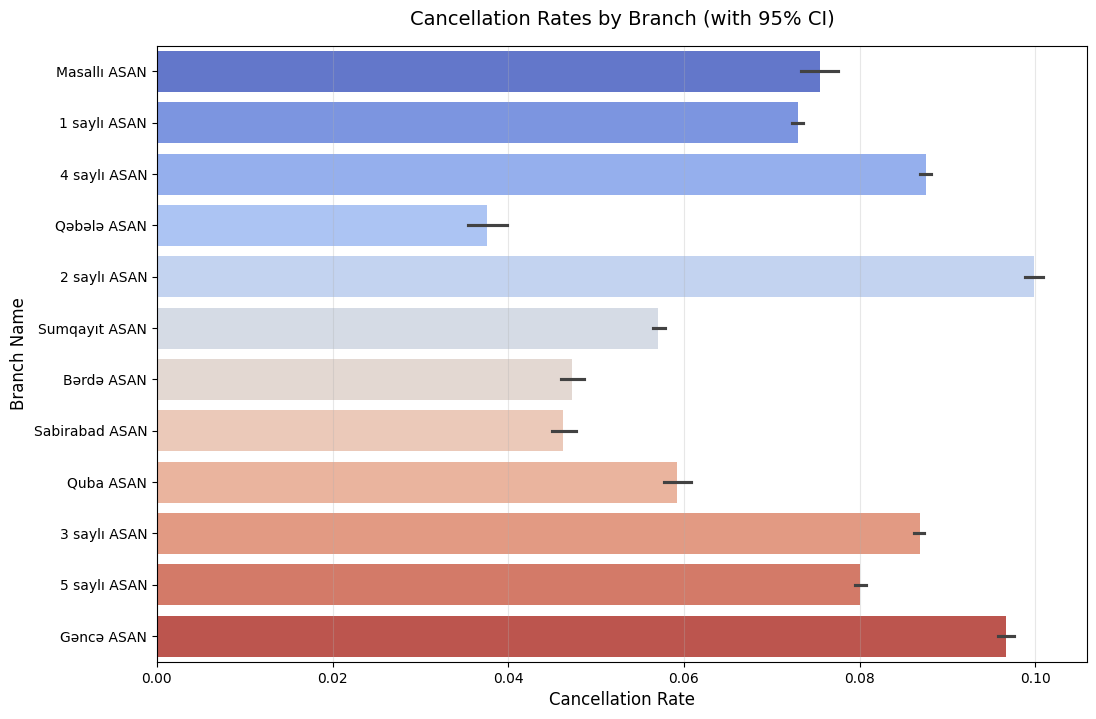

In [10]:
# Branch analysis with 95% confidence intervals
plt.figure(figsize=(12, 8))
sns.barplot(x='service_canceled', y='branch_name', 
            data=train_df, ci=95, palette='coolwarm')
plt.title('Cancellation Rates by Branch (with 95% CI)', fontsize=14, pad=15)
plt.xlabel('Cancellation Rate', fontsize=12)
plt.ylabel('Branch Name', fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.show()

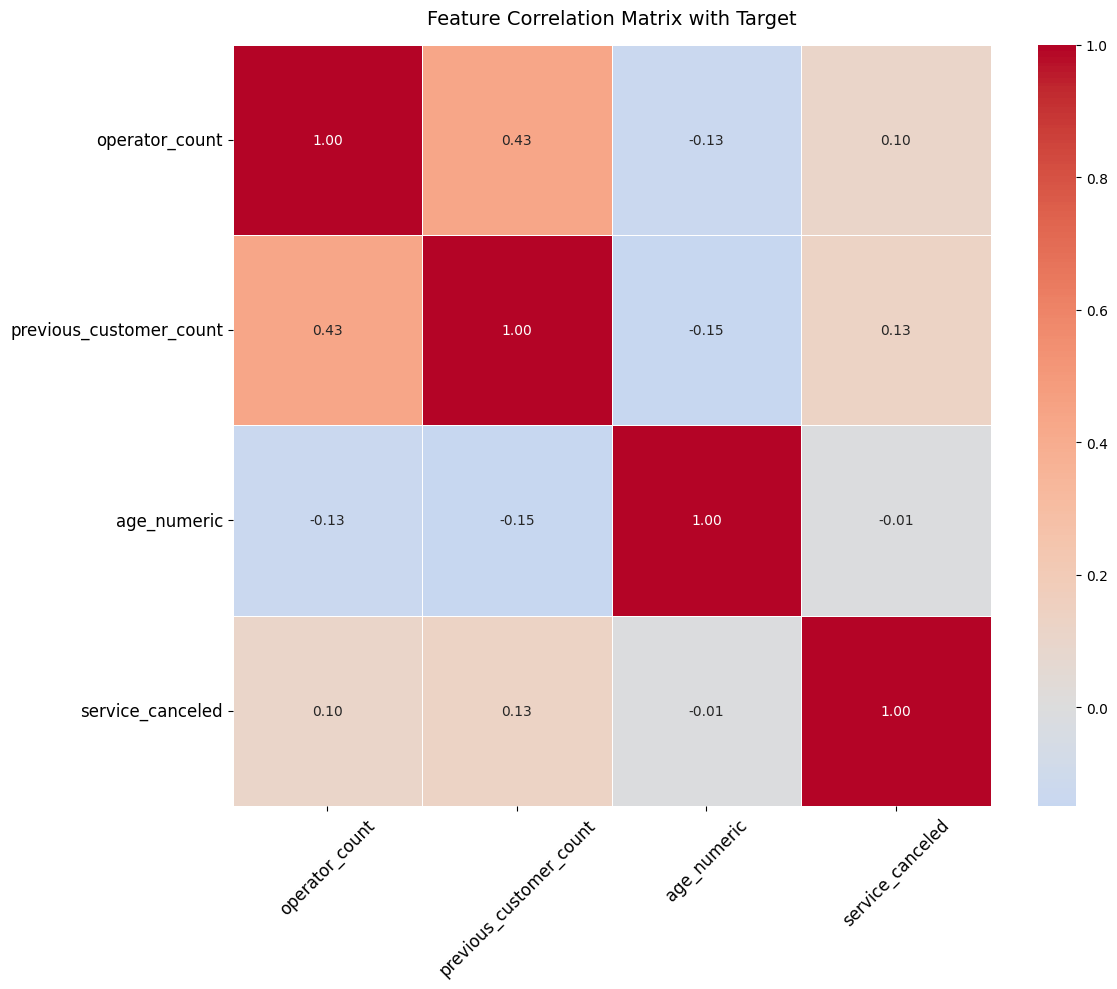

Correlation with target variable (service_canceled):
service_canceled           1.000000
previous_customer_count    0.130171
operator_count             0.102640
age_numeric               -0.008726
Name: service_canceled, dtype: float64


In [11]:

def calculate_correlations(train_df):
    if 'age_numeric' not in train_df.columns:
        def age_to_numeric(age_str):
            if isinstance(age_str, str):
                if '-' in age_str:
                    return np.mean([int(x) for x in age_str.split('-')])
                try:
                    return float(age_str)
                except:
                    return np.nan
            return np.nan
        
        train_df['age_numeric'] = train_df['customer_age_appl'].apply(age_to_numeric)
        
        median_age = train_df['age_numeric'].median()
        train_df['age_numeric'] = train_df['age_numeric'].fillna(median_age)
    
    available_features = []
    potential_features = [
        'operator_count',
        'previous_customer_count',
        'age_numeric',
        'service_popularity',
        'branch_mean_queue',
        'time_since_last'    
    ]
    
    for feature in potential_features:
        if feature in train_df.columns:
            available_features.append(feature)
    
    # Ensure we have features to analyze
    if not available_features:
        raise ValueError("No numerical features available for correlation analysis")
    
    # Add target variable
    analysis_features = available_features + ['service_canceled']
    
    # Calculate correlations
    corr_matrix = train_df[analysis_features].corr(numeric_only=True)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
                annot_kws={"size": 10}, fmt='.2f', linewidths=0.5)
    plt.title('Feature Correlation Matrix with Target', fontsize=14, pad=15)
    plt.xticks(fontsize=12, rotation=45)
    plt.yticks(fontsize=12, rotation=0)
    plt.tight_layout()
    plt.show()
    
    return corr_matrix

# Execute the analysis
correlation_matrix = calculate_correlations(train_df.copy())
print("Correlation with target variable (service_canceled):")
print(correlation_matrix['service_canceled'].sort_values(ascending=False))